# Report on CVS-like strategies
This notebook reports different statistics and visuals on the use of CVS-like strategies by students

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import mannwhitneyu
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 10, 7
from matplotlib.backends.backend_pdf import PdfPages
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

## Definitions of CVS
We use somewhat loose definitions of CVS

## For table
For each log file, we grab all of the different states of the table for a student. We analyze the tables for the following:
* a set of points collected with consecutive trial numbers
* this set of points must have been collected when the laser was on or the battery was connected
* only one variable must be varied and all others were controlled.
Since students could do CVS for a variable many times, we only keep track of the maximum number of data points when doing CVS per variable.

## For grah
For each log file, we grab all of the different states of the graph for a student. We analyze the graphs for the following:
* a set of points that are in the graph (not consecutive)
* this set of points must have been collected when the laser was on or the battery was connected
* only one variable must be varied and all others were controlled.
* one of the axes is set to the variable that is varied
* one of the axes is set to the outcome variable
Since students might make multiple graphs for a variable, we only keep track of the maximum number of data points when doing CVS in the graph per variable

# Preparing the data
First we load the data generated by the cvs_skills_detector.ipynb
We also grab the order in which students did the activities (light absorbance then caps or vice versa) using the metadata file and we adjust the detection of CVS given how large the sample size should be to consider use of CVS. Currently, we require students to capture 3 pts while controling variables to be considered doing CVS for the varied variable.

Here is what the data looks like:

In [3]:
table_cvs_df = pd.read_csv('table_cvs_results.txt', sep='\t')
graph_cvs_df = pd.read_csv('graph_cvs_results.txt', sep='\t')

In [4]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
graph_cvs_df['activity order'] = graph_cvs_df.studentid.apply(lambda sid: order[sid])
table_cvs_df['activity order'] = table_cvs_df.studentid.apply(lambda sid: order[sid])

In [5]:
graph_cvs_df = graph_cvs_df.replace(to_replace=2,value=0)
table_cvs_df = table_cvs_df.replace(to_replace=2,value=0)
table_cvs_df.head()

,studentid,Battery voltage,Area,Separation,Wavelength,Width,Concentration,activity order
0,11612162,0,0,0,3,0,3,CL
1,13660166,0,0,0,0,0,14,LC
2,41947147,0,0,0,14,6,7,CL
3,64006159,0,0,0,5,0,6,LC
4,15749160,0,0,3,0,4,10,CL


In [6]:
variables = ["Battery voltage","Area","Separation","Wavelength","Width","Concentration"]

def binarize(number):
    if number>0 : return 1
    else: return 0

graph_cvs_df2 = graph_cvs_df.copy()
for v in variables:
    graph_cvs_df2[v] = graph_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

table_cvs_df2 = table_cvs_df.copy()
for v in variables:
    table_cvs_df2[v] = table_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

graph_cvs_df2['sum'] = graph_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum'] = table_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum caps'] = table_cvs_df2[['Battery voltage','Area','Separation']].sum(axis=1)
table_cvs_df2['sum light absorbance'] = table_cvs_df2[["Wavelength","Width","Concentration"]].sum(axis=1)
graph_cvs_df2['sum caps'] = graph_cvs_df2[['Battery voltage','Area','Separation']].sum(axis=1)
graph_cvs_df2['sum light absorbance'] = graph_cvs_df2[["Wavelength","Width","Concentration"]].sum(axis=1)

Before we dig into specifics let's figure out what how often students to CVS and on how many variables:

In [7]:
print "Of all {0} students, {1} didn't do CVS in the table and {2} didn't in the graph.".format(len(table_cvs_df2), sum(table_cvs_df2['sum']==0),sum(graph_cvs_df2['sum']==0))

Of all 149 students, 14 didn't do CVS in the table and 47 didn't in the graph.


# CVS in the table - how is it used?

## How many students are doing CVS for each variable?

In [8]:
print "Percentage of students doing CVS for variable in table."
p = [['',' %']]
for v in variables:
    p.append([v,round(np.mean(table_cvs_df2[v].values)*100,1)])
print tabulate(p)

Percentage of students doing CVS for variable in table.
---------------  ----
                 %
Battery voltage  47.7
Area             56.4
Separation       53.0
Wavelength       59.7
Width            59.7
Concentration    65.1
---------------  ----


CVS was done between 47 and 65 % of the time per variable. Battery voltage the least (no surprise there). Concentration the most, maybe because it had the easiest controls (with the tick marks)?

## When they do CVS, how many points do they take?

In [9]:
print "Mean sample size for each variable, excluding sample sizes of zero."
p = [['',' Mean number of pts']]
for v in variables:
    p.append([v,str(round(np.mean(table_cvs_df[table_cvs_df[v]!=0][v].values),1))+' +/- '+ str(round(np.std(table_cvs_df[table_cvs_df[v]!=0][v].values),1))])
print tabulate(p)

Mean sample size for each variable, excluding sample sizes of zero.
---------------  ------------------
                 Mean number of pts
Battery voltage  5.9 +/- 2.3
Area             6.0 +/- 3.0
Separation       5.8 +/- 2.5
Wavelength       8.3 +/- 4.7
Width            6.8 +/- 3.9
Concentration    6.4 +/- 2.8
---------------  ------------------


***note:** this is the mean for sample size given students did use cvs (excluding zeroes)*

most are between 6-7. Wavelength stands out with a average of 8. No surprise there given the complexity of the relationship. Still 5-6 as a sample size is substantial!

## Great so they use it, but are students consistent in their use of CVS accross sims?

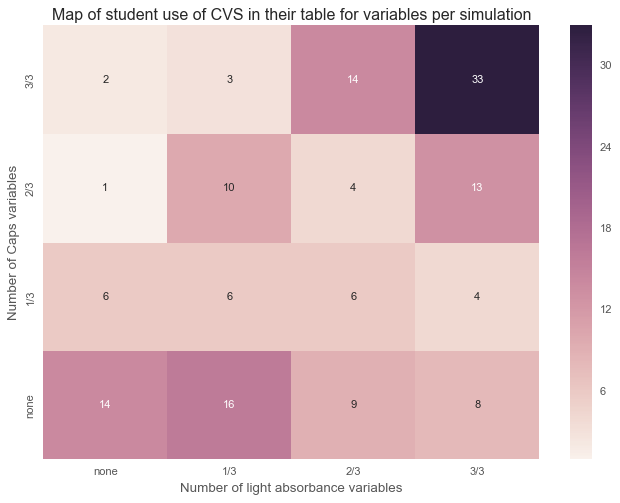

In [10]:
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum light absorbance']==j)])
ax = sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d")
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of light absorbance variables')
plt.ylabel('Number of Caps variables')
plt.title('Map of student use of CVS in their table for variables per simulation')

Overall their behavior is not consistent between sims (absence of diagonal). However students who use CVS on 2 or 3 variables tend to do so for both sims (heavy upper corner). Another pattern we see is that students who do not use CVS in the capacitance sim are still 70% likely to use CVS in the light absorbance sim (lowest row: (16+9+8=) 35 students out of (14+16+9+8=) 49).

Heavy use of CVS is consitent
<p> &#9654; CVS proficient students are systematic </p>

Low use of CVS is different between sims
<p> &#9654; CVS non-proficient students are not systematic </p>
___
**NOTE:** We should use this visualization to find groups of students whose activity might be interesting to visualize. For example, the 14 (out of 149, so ~ 10%) of students who never use CVS. What do they do? Are they still be systematic in their inquiry but using a different strategy?

# Activity order and student learning in inquiry - part 1.
Next we investigate how the order in which they do the activities changes the way they use CVS. We know that many students were familiar with the physical concepts of Beer's law, some have already studied it in class. Also the Light absorbance sim presents more physically grounded concepts (light, concentration, etc...) then the capacitance sim (electric circuit with a capacitor).

## Does order matter in their consistency?

In [11]:
print "Of all {0} students, {1} did the order CL and {2} did LC".format(len(table_cvs_df2), sum(table_cvs_df2['activity order']=='CL'),sum(graph_cvs_df2['activity order']=='LC'))

Of all 149 students, 72 did the order CL and 77 did LC


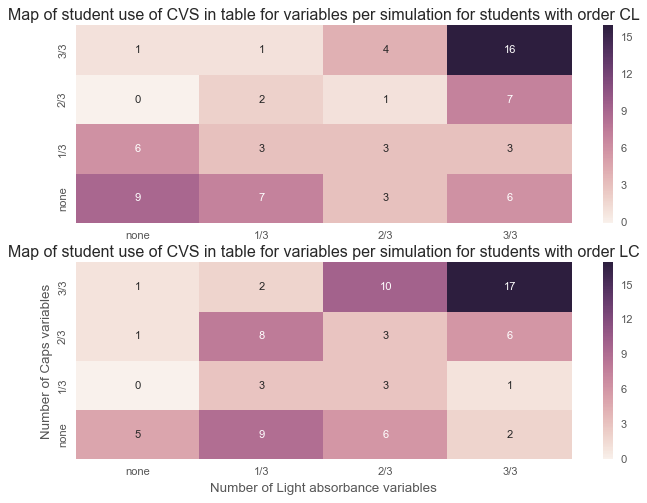

In [12]:
f, (ax1, ax2) = plt.subplots(2)
ax = ax1
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum light absorbance']==j)&(table_cvs_df2['activity order']=='CL')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d",ax=ax1)
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in table for variables per simulation for students with order CL')

ax = ax2
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum light absorbance']==j)&(table_cvs_df2['activity order']=='LC')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d", ax=ax2)
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in table for variables per simulation for students with order LC')

When light absorbance sim is second, the heatmap is bottom right triangle heavy, thus students in this condition are more likely to do CVS on more variables in light absorbance. Hypothesis: students tried/practiced CVS in caps and used it more in the light absorbance (second) sim.

When the caps sim is second, different pattern appears. First, there are still students in this condition that are still likely to do CVS in light absorbance but not in caps. However, student who did CVS with 1 or 2 variables in light absorbance are likely to do so with 2 or 3 variable in capacitance (see the cells with 8 and 10). Students that practiced CVS in light absorbance, were likely to apply it more in caps. More evidence of learning!

## Does order matter in terms of the number of CVS points they have in their table? (More pts = more deliberate, better sampling?)

In [13]:
print "Mean sample size for each variable, excluding sample sizes of zero by activity order."
p = [['','CL','LC',"Mann Whitney U",'p-value']]
for v in variables:
    s_CL = table_cvs_df[(table_cvs_df[v]!=0)&(table_cvs_df['activity order']=='CL')][v].values
    s_LC = table_cvs_df[(table_cvs_df[v]!=0)&(table_cvs_df['activity order']=='LC')][v].values
    m,pv = mannwhitneyu(s_CL,s_LC)
    p.append([v,str(round(np.mean(s_CL),1))+' +- '+str(round(np.std(s_CL),1)),str(round(np.mean(s_LC),1))+' +- '+str(round(np.std(s_LC),1)),m,round(pv,3)])
print tabulate(p)

Mean sample size for each variable, excluding sample sizes of zero by activity order.
---------------  ----------  ----------  --------------  -------
                 CL          LC          Mann Whitney U  p-value
Battery voltage  5.8 +- 2.6  6.1 +- 2.0  541.0           0.155
Area             6.2 +- 3.2  6.0 +- 2.8  829.0           0.456
Separation       5.6 +- 2.2  6.0 +- 2.7  725.0           0.346
Wavelength       8.8 +- 4.4  7.8 +- 4.9  820.0           0.082
Width            7.7 +- 4.0  6.0 +- 3.6  647.5           0.002
Concentration    6.7 +- 3.1  6.1 +- 2.6  1020.0          0.133
---------------  ----------  ----------  --------------  -------


For all variables except Area there is an increase in sample size when the sim is second. There is a higher increase for light absorbance sim variables. However none are significant except for Width (p < 0.01).

# Plotting CVS data  - how is it used?
Once they have CVS like data in their table -do they plot them (with the right axes labels)?

## How many students are plotting CVS data?

In [14]:
print "Percentage of students doing CVS for variable in table and graph."
p = [['',' % in table',' % in graph']]
for v in variables:
    p.append([v,round(np.mean(table_cvs_df2[v].values)*100,1),round(np.mean(graph_cvs_df2[v].values)*100,1)])
print tabulate(p)

Percentage of students doing CVS for variable in table and graph.
---------------  ----------  ----------
                 % in table  % in graph
Battery voltage  47.7        22.8
Area             56.4        43.6
Separation       53.0        43.0
Wavelength       59.7        30.9
Width            59.7        44.3
Concentration    65.1        50.3
---------------  ----------  ----------


Again, the quantitative variables are plotted by a similar proportion of students. Battery voltage is rarely used, and Wavelength is used slightly less despite being captured in the table as often as other variables. This is not surprise since plotting these qualitative variables involves realizing that they have to use trial number to do so.

## How many students are plotting their data, versus only doing CVS in the table, per variable? 
Some variables are perhaps more likely to be captured in a CVS way to be analyzed in the table versus graph.

In [15]:
p = [['','neither','only table','only graph','both']]
for var in ["Battery voltage","Area","Separation","Wavelength","Width","Concentration"]:
    none = len(set(table_cvs_df2[(table_cvs_df2[var]==0)].index.values).intersection(set(graph_cvs_df2[(graph_cvs_df2[var]==0)].index.values)))/float(len(table_cvs_df2))
    table = len(set(table_cvs_df2[(table_cvs_df2[var]==1)].index.values).intersection(set(graph_cvs_df2[(graph_cvs_df2[var]==0)].index.values)))/float(len(table_cvs_df2))
    graph = len(set(table_cvs_df2[(table_cvs_df2[var]==0)].index.values).intersection(set(graph_cvs_df2[(graph_cvs_df2[var]==1)].index.values)))/float(len(table_cvs_df2))
    both = len(set(table_cvs_df2[(table_cvs_df2[var]==1)].index.values).intersection(set(graph_cvs_df2[(graph_cvs_df2[var]==1)].index.values)))/float(len(table_cvs_df2))
    p.append([var,round(none*100,1),round(table*100,1),round(graph*100,1),round(both*100,1)])
print tabulate(p)

---------------  -------  ----------  ----------  ----
                 neither  only table  only graph  both
Battery voltage  52.3     24.8        0.0         22.8
Area             43.6     12.8        0.0         43.6
Separation       47.0     10.1        0.0         43.0
Wavelength       40.3     28.9        0.0         30.9
Width            40.3     15.4        0.0         44.3
Concentration    34.9     14.8        0.0         50.3
---------------  -------  ----------  ----------  ----


For all quantitative variables, there are few students who only do CVS in the table (~10%). Most will do both CVS in the table and then in their graph (43-50%)

## Does plotting CVS data change the sample size used?

In [16]:
print "Mean sample size for each variable, excluding sample sizes of zero."
p = [['','Proportion of table only',' Mean for table only','Mean for graph',"Mann Whitney U","p-value"]]
for v in variables:
    table_only = table_cvs_df[(table_cvs_df["studentid"].isin(graph_cvs_df[graph_cvs_df[v]==0]["studentid"]))&(table_cvs_df[v]!=0)][v].values
    graph = graph_cvs_df[graph_cvs_df[v]!=0][v].values
    m,pv = mannwhitneyu(table_only, graph)
    p.append([v, str(len(table_only))+"/"+str(len(table_only)+len(graph)), str(round(np.mean(table_only),1))+' +- '+str(round(np.std(table_only),1)), str(round(np.mean(graph),1))+' +- '+str(round(np.std(graph),1)),m,round(pv,5)])
print tabulate(p)

Mean sample size for each variable, excluding sample sizes of zero.
---------------  ------------------------  -------------------  --------------  --------------  -------
                 Proportion of table only  Mean for table only  Mean for graph  Mann Whitney U  p-value
Battery voltage  37/71                     5.2 +- 2.4           6.3 +- 1.9      394.5           0.0032
Area             19/84                     3.9 +- 1.7           6.3 +- 2.6      205.0           0.0
Separation       15/79                     3.7 +- 1.5           5.8 +- 2.0      120.0           0.0
Wavelength       43/89                     6.0 +- 2.9           9.7 +- 4.7      480.0           1e-05
Width            23/89                     4.7 +- 1.8           7.1 +- 3.9      413.0           0.00053
Concentration    22/97                     4.9 +- 2.4           6.5 +- 2.9      485.0           0.00157
---------------  ------------------------  -------------------  --------------  --------------  -------


If students plot their CVS-like data, they tend to have a larger sample size for all variables! This hints at the fact that students who collect data in a CVS way do so differently depending on their goal: analyze in table or analyze in graph.

## Are student's consistency different in their use of CVS accross sims when plotting CVS data?

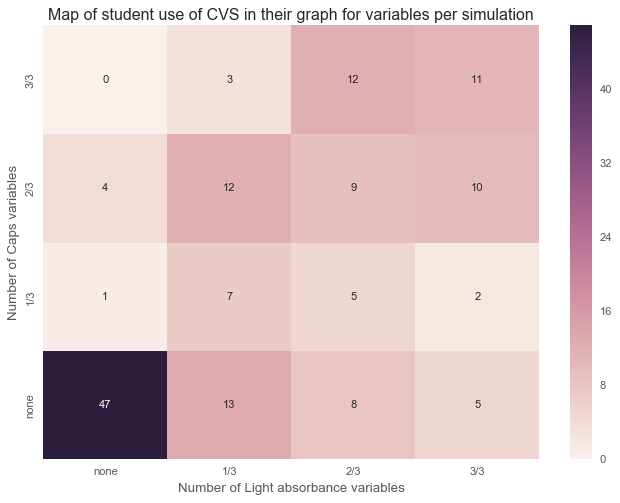

In [17]:
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(graph_cvs_df2[(graph_cvs_df2['sum caps']==i)&(graph_cvs_df2['sum light absorbance']==j)])
ax = sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d")
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
plt.title('Map of student use of CVS in their graph for variables per simulation')

The first thing we observe is that almost a third of students don't plot CVS-like data in either sim. The patterns we had when looking at CVS in a table reappear here:
* student who do CVS with 2-3 variables do so consistently accross sims (upper right corner). 
<p> &#9654; CVS proficient students are systematic in their CVS table and graph strategy </p>
* students for don't use CVS in their graph for capacitor might still do so for light absorbance sim.
<p> &#9654; CVS non-proficient students are not systematic in their CVS table and graph strategy </p>

# Activity order and student learning in inquiry - part 2: using graphs.

## Does order matter in terms of students using CVS in table only versus table in graph?

In [18]:
p = [['Variable','Order','neither','only table','graph and table']]

for var in ["Battery voltage","Area","Separation","Wavelength","Width","Concentration"]:
    noneCL = len(set(table_cvs_df2[(table_cvs_df2[var]==0)&(table_cvs_df2['activity order']=='CL')].index.values).intersection(set(graph_cvs_df2[(graph_cvs_df2[var]==0)&(graph_cvs_df2['activity order']=='CL')].index.values)))/float(len(table_cvs_df2[table_cvs_df2['activity order']=='CL']))
    noneLC = len(set(table_cvs_df2[(table_cvs_df2[var]==0)&(table_cvs_df2['activity order']=='LC')].index.values).intersection(set(graph_cvs_df2[(graph_cvs_df2[var]==0)&(graph_cvs_df2['activity order']=='LC')].index.values)))/float(len(table_cvs_df2[table_cvs_df2['activity order']=='LC']))
    tableCL = len(set(table_cvs_df2[(table_cvs_df2[var]==1)&(table_cvs_df2['activity order']=='CL')].index.values).intersection(set(graph_cvs_df2[(graph_cvs_df2[var]==0)&(graph_cvs_df2['activity order']=='CL')].index.values)))/float(len(table_cvs_df2[table_cvs_df2['activity order']=='CL']))
    tableLC = len(set(table_cvs_df2[(table_cvs_df2[var]==1)&(table_cvs_df2['activity order']=='LC')].index.values).intersection(set(graph_cvs_df2[(graph_cvs_df2[var]==0)&(graph_cvs_df2['activity order']=='LC')].index.values)))/float(len(table_cvs_df2[table_cvs_df2['activity order']=='LC']))
    graphCL = len(set(table_cvs_df2[(table_cvs_df2[var]==0)&(table_cvs_df2['activity order']=='CL')].index.values).intersection(set(graph_cvs_df2[(graph_cvs_df2[var]==1)&(graph_cvs_df2['activity order']=='CL')].index.values)))/float(len(table_cvs_df2[table_cvs_df2['activity order']=='CL']))
    graphLC = len(set(table_cvs_df2[(table_cvs_df2[var]==0)&(table_cvs_df2['activity order']=='LC')].index.values).intersection(set(graph_cvs_df2[(graph_cvs_df2[var]==1)&(graph_cvs_df2['activity order']=='LC')].index.values)))/float(len(table_cvs_df2[table_cvs_df2['activity order']=='LC']))
    bothCL = len(set(table_cvs_df2[(table_cvs_df2[var]==1)&(table_cvs_df2['activity order']=='CL')].index.values).intersection(set(graph_cvs_df2[(graph_cvs_df2[var]==1)&(graph_cvs_df2['activity order']=='CL')].index.values)))/float(len(table_cvs_df2[table_cvs_df2['activity order']=='CL']))
    bothLC = len(set(table_cvs_df2[(table_cvs_df2[var]==1)&(table_cvs_df2['activity order']=='LC')].index.values).intersection(set(graph_cvs_df2[(graph_cvs_df2[var]==1)&(graph_cvs_df2['activity order']=='LC')].index.values)))/float(len(table_cvs_df2[table_cvs_df2['activity order']=='LC']))
    p.append([var,'LC',round(noneLC*100,1),round(tableLC*100,1),round(bothLC*100,1)])
    p.append(['        ','CL',round(noneCL*100,1),round(tableCL*100,1),round(bothCL*100,1)])
    p.append(['','','','',''])
print tabulate(p)


---------------  -----  -------  ----------  ---------------
Variable         Order  neither  only table  graph and table
Battery voltage  LC     51.9     24.7        23.4
                 CL     52.8     25.0        22.2

Area             LC     33.8     13.0        53.2
                 CL     54.2     12.5        33.3

Separation       LC     41.6     9.1         49.4
                 CL     52.8     11.1        36.1

Wavelength       LC     40.3     32.5        27.3
                 CL     40.3     25.0        34.7

Width            LC     39.0     22.1        39.0
                 CL     41.7     8.3         50.0

Concentration    LC     33.8     18.2        48.1
                 CL     36.1     11.1        52.8

---------------  -----  -------  ----------  ---------------


For capacitance quantitative variables, doing the activity second decreases the likelihood of not using CVS at all, increases the likelihood of plotting CVS without affecting the likelihood of only doing CVS in the table.
<p> &#9654; Students learn to use collect CVS data in the second capacitance sim and plot it</p>
For light absorbance sim all variables, there is little change in those that don't use CVS, a decrease in table only and an increase in graph.
<p> &#9654; Students learn to use the graph to analyze their CVS-like data in the second light absorbance sim </p>

## Does order matter in their consistency of CVS usage in graphs?

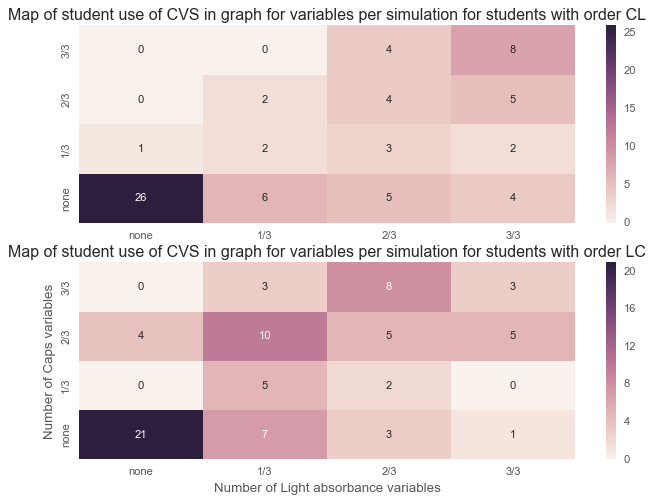

In [19]:
f, (ax1, ax2) = plt.subplots(2)
ax = ax1
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(graph_cvs_df2[(graph_cvs_df2['sum caps']==i)&(graph_cvs_df2['sum light absorbance']==j)&(graph_cvs_df2['activity order']=='CL')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d",ax=ax1)
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in graph for variables per simulation for students with order CL')

ax = ax2
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(graph_cvs_df2[(graph_cvs_df2['sum caps']==i)&(graph_cvs_df2['sum light absorbance']==j)&(graph_cvs_df2['activity order']=='LC')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d", ax=ax2)
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Light absorbance variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in graph for variables per simulation for students with order LC')

Here we see the similar patterns as for table.

When light absorbance sim is second, the heatmap is bottom right triangle heavy, thus students in this condition are more likely to do CVS on more variables in light absorbance.

When the caps sim is second, students in this condition that are still likely to do CVS in light absorbance but not in caps. Also, student who did CVS with 1 or 2 variables in light absorbance are likely to do so with 2 or 3 variable in capacitance (see the cells with 8 and 10) -> more evidence of learning.

## Does order matter in terms of the number of CVS points they plot? (More pts = more deliberate, better sampling?)

In [20]:
print "Mean sample size for each variable, excluding sample sizes of zero by activity order."
p = [['','CL','LC',"Mann Whitney U",'p-value']]
for v in variables:
    s_CL = graph_cvs_df[(graph_cvs_df[v]!=0)&(graph_cvs_df['activity order']=='CL')][v].values
    s_LC = graph_cvs_df[(graph_cvs_df[v]!=0)&(graph_cvs_df['activity order']=='LC')][v].values
    m,pv = mannwhitneyu(s_CL,s_LC)
    p.append([v,str(round(np.mean(s_CL),1))+' +- '+str(round(np.std(s_CL),1)),str(round(np.mean(s_LC),1))+' +- '+str(round(np.std(s_LC),1)),m,round(pv,3)])
print tabulate(p)

Mean sample size for each variable, excluding sample sizes of zero by activity order.
---------------  ----------  -----------  --------------  -------
                 CL          LC           Mann Whitney U  p-value
Battery voltage  5.9 +- 2.2  6.7 +- 1.4   98.0            0.055
Area             6.6 +- 2.7  6.2 +- 2.5   447.5           0.273
Separation       5.8 +- 1.6  5.8 +- 2.3   448.0           0.262
Wavelength       9.5 +- 3.9  10.0 +- 5.4  258.0           0.465
Width            7.5 +- 3.9  6.6 +- 3.9   424.0           0.066
Concentration    6.9 +- 3.0  6.1 +- 2.6   555.0           0.057
---------------  ----------  -----------  --------------  -------


Increase in sample size with second sim variables is still present for quantitative light absorbance sim variables, but not caps (unless battery voltage)... However nothing is significant.